# Discrete Elastic Shells: Simple Example with Four Nodes
Copyright M. Khalid Jawed (khalidjm@seas.ucla.edu). License: CC BY-NC
You should use this code at your own risk.

#Load Libraries

# Discrete Elastic Shells: Simple Example with Four Nodes
Copyright M. Khalid Jawed (khalidjm@seas.ucla.edu). License: CC BY-NC
You should use this code at your own risk.

In [155]:
%pip install pygmsh
# %apt-get update
# %apt-get install libglu1-mesa-dev
# %apt-get install imagemagick

Note: you may need to restart the kernel to use updated packages.


In [156]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from collections import defaultdict
import pygmsh
import meshio
# from google.colab import files
from matplotlib.animation import FuncAnimation

#Miscellaneous Functions: signedAngle, rotateAxisAngle, parallel_transport, crossMat

In [157]:
def signedAngle(u = None,v = None,n = None):
    # This function calculates the signed angle between two vectors, "u" and "v",
    # using an optional axis vector "n" to determine the direction of the angle.
    #
    # Parameters:
    #   u: numpy array-like, shape (3,), the first vector.
    #   v: numpy array-like, shape (3,), the second vector.
    #   n: numpy array-like, shape (3,), the axis vector that defines the plane
    #      in which the angle is measured. It determines the sign of the angle.
    #
    # Returns:
    #   angle: float, the signed angle (in radians) from vector "u" to vector "v".
    #          The angle is positive if the rotation from "u" to "v" follows
    #          the right-hand rule with respect to the axis "n", and negative otherwise.
    #
    # The function works by:
    # 1. Computing the cross product "w" of "u" and "v" to find the vector orthogonal
    #    to both "u" and "v".
    # 2. Calculating the angle between "u" and "v" using the arctan2 function, which
    #    returns the angle based on the norm of "w" (magnitude of the cross product)
    #    and the dot product of "u" and "v".
    # 3. Using the dot product of "n" and "w" to determine the sign of the angle.
    #    If this dot product is negative, the angle is adjusted to be negative.
    #
    # Example:
    #   signedAngle(np.array([1, 0, 0]), np.array([0, 1, 0]), np.array([0, 0, 1]))
    #   This would return a positive angle (π/2 radians), as the rotation
    #   from the x-axis to the y-axis is counterclockwise when viewed along the z-axis.
    w = np.cross(u,v)
    angle = np.arctan2( np.linalg.norm(w), np.dot(u,v) )
    if (np.dot(n,w) < 0):
        angle = - angle

    return angle

In [158]:
def mmt(matrix):
    return matrix + matrix.T

# Hinge angle, its gradient, and Hessian

In [159]:
#          x2
#          /\
#         /  \
#      e1/    \e3
#       /  t0  \
#      /        \
#     /    e0    \
#   x0------------x1
#     \          /
#      \   t1   /
#       \      /
#      e2\    /e4
#         \  /
#          \/
#          x3
#
#  Edge orientation: e0,e1,e2 point away from x0
#                       e3,e4 point away from x1

In [160]:
def getTheta(x0, x1 = None, x2 = None, x3 = None):

    if np.size(x0) == 12:  # Allow another type of input where x0 contains all the info
      x1 = x0[3:6]
      x2 = x0[6:9]
      x3 = x0[9:12]
      x0 = x0[0:3]

    m_e0 = x1 - x0
    m_e1 = x2 - x0
    m_e2 = x3 - x0

    n0 = np.cross(m_e0, m_e1)
    n1 = np.cross(m_e2, m_e0)

    # Calculate the signed angle using the provided function
    theta = signedAngle(n0, n1, m_e0)

    return theta

In [161]:
# In the original code, there are probaly TWO sign errors in the expressions for m_h3 and m_h4.
# [Original code: % https://github.com/shift09/plates-shells/blob/master/src/bending.cpp]
# I indicated those two corrections by writing the word "CORRECTION" next
# to them.

def gradTheta(x0, x1 = None, x2 = None, x3 = None):

    if np.size(x0) == 12:  # Allow another type of input where x0 contains all the info
      x1 = x0[3:6]
      x2 = x0[6:9]
      x3 = x0[9:12]
      x0 = x0[0:3]

    m_e0 = x1 - x0
    m_e1 = x2 - x0
    m_e2 = x3 - x0
    m_e3 = x2 - x1
    m_e4 = x3 - x1

    m_cosA1 = np.dot(m_e0, m_e1) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e1))
    m_cosA2 = np.dot(m_e0, m_e2) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e2))
    m_cosA3 = -np.dot(m_e0, m_e3) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e3))
    m_cosA4 = -np.dot(m_e0, m_e4) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e4))

    m_sinA1 = np.linalg.norm(np.cross(m_e0, m_e1)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e1))
    m_sinA2 = np.linalg.norm(np.cross(m_e0, m_e2)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e2))
    m_sinA3 = -np.linalg.norm(np.cross(m_e0, m_e3)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e3))
    m_sinA4 = -np.linalg.norm(np.cross(m_e0, m_e4)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e4))

    m_nn1 = np.cross(m_e0, m_e3)
    m_nn1 = m_nn1 / np.linalg.norm(m_nn1)
    m_nn2 = -np.cross(m_e0, m_e4)
    m_nn2 = m_nn2 / np.linalg.norm(m_nn2)

    m_h1 = np.linalg.norm(m_e0) * m_sinA1
    m_h2 = np.linalg.norm(m_e0) * m_sinA2
    m_h3 = -np.linalg.norm(m_e0) * m_sinA3  # CORRECTION
    m_h4 = -np.linalg.norm(m_e0) * m_sinA4  # CORRECTION
    m_h01 = np.linalg.norm(m_e1) * m_sinA1
    m_h02 = np.linalg.norm(m_e2) * m_sinA2

    # Initialize the gradient
    gradTheta = np.zeros(12)

    gradTheta[0:3] = m_cosA3 * m_nn1 / m_h3 + m_cosA4 * m_nn2 / m_h4
    gradTheta[3:6] = m_cosA1 * m_nn1 / m_h1 + m_cosA2 * m_nn2 / m_h2
    gradTheta[6:9] = -m_nn1 / m_h01
    gradTheta[9:12] = -m_nn2 / m_h02

    return gradTheta

In [162]:
def hessTheta(x0, x1 = None, x2 = None, x3 = None):

    if np.size(x0) == 12:  # Allow another type of input where x0 contains all the info
      x1 = x0[3:6]
      x2 = x0[6:9]
      x3 = x0[9:12]
      x0 = x0[0:3]

    m_e0 = x1 - x0
    m_e1 = x2 - x0
    m_e2 = x3 - x0
    m_e3 = x2 - x1
    m_e4 = x3 - x1

    m_cosA1 = np.dot(m_e0, m_e1) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e1))
    m_cosA2 = np.dot(m_e0, m_e2) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e2))
    m_cosA3 = -np.dot(m_e0, m_e3) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e3))
    m_cosA4 = -np.dot(m_e0, m_e4) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e4))

    m_sinA1 = np.linalg.norm(np.cross(m_e0, m_e1)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e1))
    m_sinA2 = np.linalg.norm(np.cross(m_e0, m_e2)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e2))
    m_sinA3 = -np.linalg.norm(np.cross(m_e0, m_e3)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e3))
    m_sinA4 = -np.linalg.norm(np.cross(m_e0, m_e4)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e4))

    m_nn1 = np.cross(m_e0, m_e3)
    m_nn1 /= np.linalg.norm(m_nn1)
    m_nn2 = -np.cross(m_e0, m_e4)
    m_nn2 /= np.linalg.norm(m_nn2)

    m_h1 = np.linalg.norm(m_e0) * m_sinA1
    m_h2 = np.linalg.norm(m_e0) * m_sinA2
    m_h3 = -np.linalg.norm(m_e0) * m_sinA3
    m_h4 = -np.linalg.norm(m_e0) * m_sinA4
    m_h01 = np.linalg.norm(m_e1) * m_sinA1
    m_h02 = np.linalg.norm(m_e2) * m_sinA2

    # Gradient of Theta (as an intermediate step)
    grad_theta = np.zeros((12, 1))
    grad_theta[0:3] = (m_cosA3 * m_nn1 / m_h3 + m_cosA4 * m_nn2 / m_h4).reshape(-1, 1)
    grad_theta[3:6] = (m_cosA1 * m_nn1 / m_h1 + m_cosA2 * m_nn2 / m_h2).reshape(-1, 1)
    grad_theta[6:9] = (-m_nn1 / m_h01).reshape(-1, 1)
    grad_theta[9:12] = (-m_nn2 / m_h02).reshape(-1, 1)

    # Intermediate matrices for Hessian
    m_m1 = np.cross(m_nn1, m_e1) / np.linalg.norm(m_e1)
    m_m2 = -np.cross(m_nn2, m_e2) / np.linalg.norm(m_e2)
    m_m3 = -np.cross(m_nn1, m_e3) / np.linalg.norm(m_e3)
    m_m4 = np.cross(m_nn2, m_e4) / np.linalg.norm(m_e4)
    m_m01 = -np.cross(m_nn1, m_e0) / np.linalg.norm(m_e0)
    m_m02 = np.cross(m_nn2, m_e0) / np.linalg.norm(m_e0)

    # Hessian matrix components
    M331 = m_cosA3 / (m_h3 ** 2) * np.outer(m_m3, m_nn1)
    M311 = m_cosA3 / (m_h3 * m_h1) * np.outer(m_m1, m_nn1)
    M131 = m_cosA1 / (m_h1 * m_h3) * np.outer(m_m3, m_nn1)
    M3011 = m_cosA3 / (m_h3 * m_h01) * np.outer(m_m01, m_nn1)
    M111 = m_cosA1 / (m_h1 ** 2) * np.outer(m_m1, m_nn1)
    M1011 = m_cosA1 / (m_h1 * m_h01) * np.outer(m_m01, m_nn1)

    M442 = m_cosA4 / (m_h4 ** 2) * np.outer(m_m4, m_nn2)
    M422 = m_cosA4 / (m_h4 * m_h2) * np.outer(m_m2, m_nn2)
    M242 = m_cosA2 / (m_h2 * m_h4) * np.outer(m_m4, m_nn2)
    M4022 = m_cosA4 / (m_h4 * m_h02) * np.outer(m_m02, m_nn2)
    M222 = m_cosA2 / (m_h2 ** 2) * np.outer(m_m2, m_nn2)
    M2022 = m_cosA2 / (m_h2 * m_h02) * np.outer(m_m02, m_nn2)

    B1 = 1 / np.linalg.norm(m_e0) ** 2 * np.outer(m_nn1, m_m01)
    B2 = 1 / np.linalg.norm(m_e0) ** 2 * np.outer(m_nn2, m_m02)

    N13 = 1 / (m_h01 * m_h3) * np.outer(m_nn1, m_m3)
    N24 = 1 / (m_h02 * m_h4) * np.outer(m_nn2, m_m4)
    N11 = 1 / (m_h01 * m_h1) * np.outer(m_nn1, m_m1)
    N22 = 1 / (m_h02 * m_h2) * np.outer(m_nn2, m_m2)
    N101 = 1 / (m_h01 ** 2) * np.outer(m_nn1, m_m01)
    N202 = 1 / (m_h02 ** 2) * np.outer(m_nn2, m_m02)

    # Initialize Hessian of Theta
    hess_theta = np.zeros((12, 12))

    hess_theta[0:3, 0:3] = mmt(M331) - B1 + mmt(M442) - B2
    hess_theta[0:3, 3:6] = M311 + M131.T + B1 + M422 + M242.T + B2
    hess_theta[0:3, 6:9] = M3011 - N13
    hess_theta[0:3, 9:12] = M4022 - N24
    hess_theta[3:6, 3:6] = mmt(M111) - B1 + mmt(M222) - B2
    hess_theta[3:6, 6:9] = M1011 - N11
    hess_theta[3:6, 9:12] = M2022 - N22
    hess_theta[6:9, 6:9] = -mmt(N101)
    hess_theta[9:12, 9:12] = -mmt(N202)

    # Make the Hessian symmetric
    hess_theta[3:6, 0:3] = hess_theta[0:3, 3:6].T
    hess_theta[6:9, 0:3] = hess_theta[0:3, 6:9].T
    hess_theta[9:12, 0:3] = hess_theta[0:3, 9:12].T
    hess_theta[6:9, 3:6] = hess_theta[3:6, 6:9].T
    hess_theta[9:12, 3:6] = hess_theta[3:6, 9:12].T

    return hess_theta


# Stretching energy for a shell, it's gradient, and Hessian

In [163]:
def gradEs_hessEs(node0 = None,node1 = None,l_k = None,EA = None):

# Inputs:
# node0: 1x3 vector - position of the first node
# node1: 1x3 vector - position of the last node

# l_k: reference length (undeformed) of the edge
# EA: scalar - stretching stiffness - Young's modulus times area

# Outputs:
# dF: 6x1  vector - gradient of the stretching energy between node0 and node 1.
# dJ: 6x6 vector - hessian of the stretching energy between node0 and node 1.

    ## Gradient of Es
    edge = node1 - node0

    edgeLen = np.linalg.norm(edge)
    tangent = edge / edgeLen
    epsX = edgeLen / l_k - 1
    dF_unit = EA * tangent * epsX
    dF = np.zeros((6))
    dF[0:3] = - dF_unit
    dF[3:6] = dF_unit

    ## Hessian of Es
    Id3 = np.eye(3)
    M = EA * ((1 / l_k - 1 / edgeLen) * Id3 + 1 / edgeLen * ( np.outer( edge, edge ) ) / edgeLen ** 2)

    dJ = np.zeros((6,6))
    dJ[0:3,0:3] = M
    dJ[3:6,3:6] = M
    dJ[0:3,3:6] = - M
    dJ[3:6,0:3] = - M
    return dF,dJ

# Bending energy for a shell, it's gradient, and Hessian

In [164]:
def getEb_Shell(x0, x1=None, x2=None, x3=None, theta_bar=0, kb=1.0):
    """
    Compute the bending energy for a shell.

    Returns:
    E (scalar): Bending energy.
    """
    # Allow another type of input where x0 contains all the information
    if np.size(x0) == 12:
        x1 = x0[3:6]
        x2 = x0[6:9]
        x3 = x0[9:12]
        x0 = x0[:3]

    # Compute theta, gradient, and Hessian
    theta = getTheta(x0, x1, x2, x3)  # Replace with your getTheta function in Python
    grad = gradTheta(x0, x1, x2, x3)  # Replace with your gradTheta function in Python

    # E = 0.5 * kb * (theta-thetaBar)^2
    E = 0.5 * kb * (theta - theta_bar) ** 2

    return E

In [165]:
def gradEb_hessEb_Shell(x0, x1=None, x2=None, x3=None, theta_bar=0, kb=1.0):
    """
    Compute the gradient and Hessian of the bending energy for a shell.

    Parameters:
    x0 (array): Can either be a 3-element array (single point) or a 12-element array.
    x1, x2, x3 (arrays): Optional, 3-element arrays specifying points.
    theta_bar (float): Reference angle.
    kb (float): Bending stiffness.

    Returns:
    dF (array): Gradient of the bending energy.
    dJ (array): Hessian of the bending energy.
    """
    # Allow another type of input where x0 contains all the information
    if np.size(x0) == 12:
        x1 = x0[3:6]
        x2 = x0[6:9]
        x3 = x0[9:12]
        x0 = x0[:3]

    # Compute theta, gradient, and Hessian
    theta = getTheta(x0, x1, x2, x3)  # Replace with your getTheta function in Python
    grad = gradTheta(x0, x1, x2, x3)  # Replace with your gradTheta function in Python

    # E = 0.5 * kb * (theta-thetaBar)^2
    # F = dE/dx = 2 * (theta-thetaBar) * gradTheta
    dF = 0.5 * kb * (2 * (theta - theta_bar) * grad)

    # E = 0.5 * kb * (theta-thetaBar)^2
    # F = 0.5 * kb * (2 (theta-thetaBar) d theta/dx)
    # J = dF/dx = 0.5 * kb * [ 2 (d theta / dx) transpose(d theta/dx) +
    #       2 (theta-thetaBar) (d^2 theta/ dx^2 ) ]
    hess = hessTheta(x0, x1, x2, x3)  # Replace with your hessTheta function in Python
    dJ = 0.5 * kb * (2 * np.outer(grad, grad) + 2 * (theta - theta_bar) * hess)

    return dF, dJ

#Plot the shell

In [166]:
# Function to set equal aspect ratio for 3D plots
def set_axes_equal(ax):
    """
    Set equal aspect ratio for a 3D plot in Matplotlib.
    This function adjusts the limits of the plot to make sure
    that the scale is equal along all three axes.
    """
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])

    max_range = max(x_range, y_range, z_range)

    x_middle = np.mean(x_limits)
    y_middle = np.mean(y_limits)
    z_middle = np.mean(z_limits)

    ax.set_xlim3d([x_middle - max_range / 2, x_middle + max_range / 2])
    ax.set_ylim3d([y_middle - max_range / 2, y_middle + max_range / 2])
    ax.set_zlim3d([z_middle - max_range / 2, z_middle + max_range / 2])

In [167]:
def plotShell(x0, ctime):
    x1 = x0[3:6]
    x2 = x0[6:9]
    x3 = x0[9:12]
    x0 = x0[0:3]

    fig = plt.figure(1)
    ax = fig.add_subplot(111, projection='3d')

    # Plot nodes
    X = np.array([x0[0], x1[0], x2[0], x0[0], x3[0], x1[0]])
    Y = np.array([x0[1], x1[1], x2[1], x0[1], x3[1], x1[1]])
    Z = np.array([x0[2], x1[2], x2[2], x0[2], x3[2], x1[2]])

    # Use the color passed in
    ax.plot3D(X, Y, Z, '-', marker='o')

    # Plot the first node with a red triangle (unchanged)
    ax.plot3D([X[0]], [Y[0]], [Z[0]], 'r^')

    # Title and labels
    ax.set_title(f't={ctime:.2f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    # Equal axes
    set_axes_equal(ax)

    plt.draw()
    plt.show()


In [168]:
def plotShell(x0, ctime, color='k'):
    x1 = x0[3:6]
    x2 = x0[6:9]
    x3 = x0[9:12]
    x0 = x0[0:3]

    fig = plt.figure(1)
    ax = fig.add_subplot(111, projection='3d')

    # Plot nodes
    X = np.array([x0[0], x1[0], x2[0], x0[0], x3[0], x1[0]])
    Y = np.array([x0[1], x1[1], x2[1], x0[1], x3[1], x1[1]])
    Z = np.array([x0[2], x1[2], x2[2], x0[2], x3[2], x1[2]])

    # Use the color passed in
    ax.plot3D(X, Y, Z, '-', color=color, marker='o')

    # Plot the first node with a red triangle (unchanged)
    ax.plot3D([X[0]], [Y[0]], [Z[0]], 'r^')

    # Title and labels
    ax.set_title(f't={ctime:.2f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    # Equal axes
    set_axes_equal(ax)

    plt.draw()
    plt.show()


In [169]:
def create_shell_plot(ctime):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')

    ax.set_title(f't={ctime:.2f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    return fig, ax

In [170]:
def set_axes_equal_hinge(ax):
    x = ax.get_xlim3d()
    y = ax.get_ylim3d()
    z = ax.get_zlim3d()
    x_range = x[1] - x[0]
    y_range = y[1] - y[0]
    z_range = z[1] - z[0]
    max_range = max(x_range, y_range, z_range) / 2

    mid_x = (x[0] + x[1]) * 0.5
    mid_y = (y[0] + y[1]) * 0.5
    mid_z = (z[0] + z[1]) * 0.5

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)


def plotShell_hinge(ax, x0, color):
    x1 = x0[3:6]
    x2 = x0[6:9]
    x3 = x0[9:12]
    x0 = x0[0:3]

    # Plot nodes
    X = np.array([x0[0], x1[0], x2[0], x0[0], x3[0], x1[0]])
    Y = np.array([x0[1], x1[1], x2[1], x0[1], x3[1], x1[1]])
    Z = np.array([x0[2], x1[2], x2[2], x0[2], x3[2], x1[2]])

    # Use the color passed in
    line, = ax.plot3D(X, Y, Z, '-', color=color, marker='o')

    # Plot the first node with a red triangle (unchanged)
    ax.plot3D([X[0]], [Y[0]], [Z[0]], 'r^')
    return [line]

def animate_hinges_accumulated(nodes, hinges, interval=1000):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')

    all_artists = []  # store all lines drawn

    def update(frame):
        hinge = hinges[frame]
        x0 = nodes[hinge[0]]
        x1 = nodes[hinge[1]]
        x2 = nodes[hinge[2]]
        x3 = nodes[hinge[3]]
        hinge_concatenated = np.concatenate((x0, x1, x2, x3))
        color = (0,0,0)
        artists = plotShell_hinge(ax, hinge_concatenated, color=color)
        all_artists.extend(artists)
        set_axes_equal_hinge(ax)
        return all_artists

    ani = FuncAnimation(fig, update, frames=len(hinges),
                        interval=interval, blit=False)
    return fig, ax, ani

In [171]:
def plot_beam(q, ctime):
  fig = plt.figure(1)
  ax = fig.add_subplot(111, projection='3d')

  for i in range(len(hinges)):
    hinge = hinges[i]
    x0 = nodes[hinge[0]]
    x1 = nodes[hinge[1]]
    x2 = nodes[hinge[2]]
    x3 = nodes[hinge[3]]
    points_of_hinge = np.concatenate((x0, x1, x2, x3))

    x1 = points_of_hinge[3:6]
    x2 = points_of_hinge[6:9]
    x3 = points_of_hinge[9:12]
    x0 = points_of_hinge[0:3]
    # Plot nodes
    X = np.array([x0[0], x1[0], x2[0], x0[0], x3[0], x1[0]])
    Y = np.array([x0[1], x1[1], x2[1], x0[1], x3[1], x1[1]])
    Z = np.array([x0[2], x1[2], x2[2], x0[2], x3[2], x1[2]])

    # Use the color passed in
    ax.plot3D(X, Y, Z, '-', marker='o', color=(0,0,0))

  # Title and labels
  ax.set_title(f't={ctime:.2f}')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')

  # Equal axes
  set_axes_equal(ax)
  ax.set_zlim(-0.04, 0.02)

  plt.draw()
  plt.show()


In [172]:
def plot_mesh(nodes, elements, ctime):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Build faces
    triangles = [nodes[e] for e in elements]

    ax.add_collection3d(
        Poly3DCollection(triangles, edgecolor='k', facecolor='lightblue', alpha=0.5)
    )

    # Set the title with current time
    ax.set_title(f't={ctime:.2f}')

    # Set axes labels
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    # Auto-scale
    x, y, z = nodes[:,0], nodes[:,1], nodes[:,2]
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())
    ax.set_zlim(z.min(), z.max())

    # Equal aspect ratio
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max()
    mid_x = (x.max()+x.min())/2
    mid_y = (y.max()+y.min())/2
    mid_z = (z.max()+z.min())/2
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

    plt.show()

# Objective function

In [173]:
def objfun(qOld, uOld, freeIndex, dt, tol, massVector, massMatrix,
           ks, refLen, edges,
           kb, thetaBar, hinges,
           Fg, visc):

  qNew = qOld.copy()
  ndof = len(qOld) # Number of DOFs

  iter = 0 # number of iteration
  error = 10 * tol
  # Newton Raphson
  while error > tol:

    # Bending force and jacobian
    Fb = np.zeros( ndof )
    Jb = np.zeros( (ndof,ndof) )
    # Loop over every "bending spring" or "hinge"
    for kHinge in range(hinges.shape[0]):
      node0 = hinges[kHinge, 0]
      node1 = hinges[kHinge, 1]
      node2 = hinges[kHinge, 2]
      node3 = hinges[kHinge, 3]
      x0 = qNew[ 3*node0: 3*node0 + 3]
      x1 = qNew[ 3*node1: 3*node1 + 3]
      x2 = qNew[ 3*node2: 3*node2 + 3]
      x3 = qNew[ 3*node3: 3*node3 + 3]
      ind = [3*node0, 3*node0 + 1, 3*node0 + 2,
             3*node1, 3*node1 + 1, 3*node1 + 2,
             3*node2, 3*node2 + 1, 3*node2 + 2,
             3*node3, 3*node3 + 1, 3*node3 + 2]
      dF, dJ = gradEb_hessEb_Shell(x0, x1, x2, x3, 0, kb)
      Fb[ind] -= dF
      Jb[np.ix_(ind,ind)] -= dJ

    # Stretching force and jacobian
    Fs = np.zeros( ndof )
    Js = np.zeros( (ndof,ndof) )
    for kEdge in range(edges.shape[0]):
      node0 = edges[kEdge, 0]
      node1 = edges[kEdge, 1]
      x0 = qNew[ 3*node0: 3*node0 + 3]
      x1 = qNew[ 3*node1: 3*node1 + 3]
      ind = [3*node0, 3*node0 + 1, 3*node0 + 2,
             3*node1, 3*node1 + 1, 3*node1 + 2]
      dF, dJ = gradEs_hessEs(x0, x1, refLen[kEdge], ks[kEdge])
      Fs[ind] -= dF
      Js[np.ix_(ind,ind)] -= dJ

    # Viscous force
    Fv = - visc * (qNew - qOld) / dt
    Jv = - visc / dt * np.eye(ndof)

    # print("Fb:", Fb.shape, "Fs:",Fs.shape, "Fg:",Fg.shape, "Fv:",Fv.shape)
    Forces = Fb + Fs + Fg + Fv # Sum of forces
    JForces = Jb + Js + Jv # Sum of Jacobians

    # Set up my equations of motion and calculating its residual (=0)
    f = massVector / dt * ( (qNew - qOld)/dt - uOld) - Forces # Residual of EOM
    J = massMatrix / dt ** 2 - JForces

    # Extract the free part of the f and J arrays
    f_free = f[freeIndex]
    J_free = J[np.ix_(freeIndex, freeIndex)]
    # Correction
    dq_free = np.linalg.solve(J_free, f_free)

    # Update my guess for position
    qNew[freeIndex] -= dq_free

    # Calculate error
    error = np.sum( np.abs(f_free))

    iter += 1

    #print('Iter = ', iter, ' error=', error)

  uNew = (qNew - qOld) / dt
  return qNew, uNew

#Main Discrete Shells

**DOFs and Nodes**

In [174]:
def mesh_plate_structured_with_clamp(l, w, nx, ny):

    # Build node grid
    nx_total = nx + 1  # +1 clamp column
    dx = l / nx
    dy = w / ny

    xs = np.linspace(-dx, l, nx_total + 1)
    ys = np.linspace(0,   w, ny + 1)

    nodes = np.array([[x, y, 0.0] for y in ys for x in xs], dtype=float)

    def idx(i, j):
        return j * (nx_total + 1) + i

    # Build triangles
    triangles = []

    for j in range(ny):
        for i in range(nx_total):
            n0 = idx(i,   j)
            n1 = idx(i+1, j)
            n2 = idx(i,   j+1)
            n3 = idx(i+1, j+1)

            if (i + j) % 2 == 0:
                triangles.append([n0, n1, n2])
                triangles.append([n1, n3, n2])
            else:
                triangles.append([n0, n1, n3])
                triangles.append([n0, n3, n2])

    triangles = np.asarray(triangles, dtype=int)

    # Build edge list from triangles
    edge_set = set()

    # map edges→list of triangles that touch that edge
    edge_to_triangles = {}

    for t_id, tri in enumerate(triangles):
        a, b, c = tri

        # Triangle edges
        tri_edges = [(a, b), (b, c), (c, a)]

        for e in tri_edges:
            e_sorted = tuple(sorted(e))  # undirected edge (0,5) same as (5,0)
            edge_set.add(e_sorted)

            # store adjacency for hinge extraction
            if e_sorted not in edge_to_triangles:
                edge_to_triangles[e_sorted] = []
            edge_to_triangles[e_sorted].append(t_id)

    # Convert edges to array
    edges = np.array(list(edge_set), dtype=int)

    # Build hinge list
    hinges = []

    for edge, tri_list in edge_to_triangles.items():
        # Hinge only exists if two triangles share this edge
        if len(tri_list) == 2:
            t1, t2 = tri_list

            tri1 = triangles[t1]
            tri2 = triangles[t2]

            i, j = edge  # shared edge nodes

            # Opposing nodes for the two triangles
            k = [n for n in tri1 if n not in edge][0]
            l = [n for n in tri2 if n not in edge][0]

            hinges.append([i, j, k, l])

    hinges = np.asarray(hinges, dtype=int)

    return nodes, triangles, edges, hinges


C:\Users\natha\AppData\Local\Temp/ipykernel_34840/3295299788.py:24: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_zlim(z.min(), z.max())


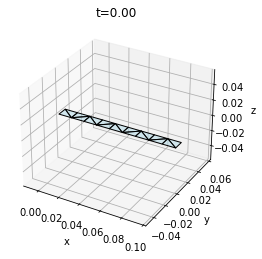

37
[ 7 17]
17
[ 1 10  0 11]
[-0.0125  0.      0.    ]
[[-0.0125  0.      0.    ]
 [ 0.      0.      0.    ]
 [ 0.0125  0.      0.    ]
 [ 0.025   0.      0.    ]
 [ 0.0375  0.      0.    ]
 [ 0.05    0.      0.    ]
 [ 0.0625  0.      0.    ]
 [ 0.075   0.      0.    ]
 [ 0.0875  0.      0.    ]
 [ 0.1     0.      0.    ]
 [-0.0125  0.01    0.    ]
 [ 0.      0.01    0.    ]
 [ 0.0125  0.01    0.    ]
 [ 0.025   0.01    0.    ]
 [ 0.0375  0.01    0.    ]
 [ 0.05    0.01    0.    ]
 [ 0.0625  0.01    0.    ]
 [ 0.075   0.01    0.    ]
 [ 0.0875  0.01    0.    ]
 [ 0.1     0.01    0.    ]]


In [175]:
l = 0.1 #m
w = 0.01 #m

nodes, triangles, edges, hinges = mesh_plate_structured_with_clamp(l, w, 8, 1)
plot_mesh(nodes, triangles, 0)

print(edges.shape[0])
print(edges[0])
print(hinges.shape[0])
print(hinges[0])
print(nodes[0])
print(nodes)

c:\Users\natha\anaconda3\lib\site-packages\matplotlib\animation.py:973: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  warnings.warn(


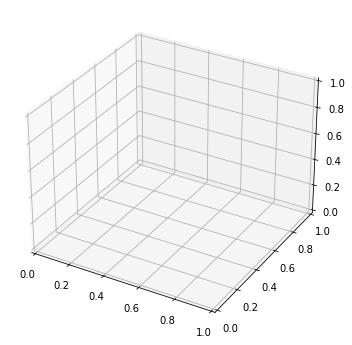

In [176]:
fig, ax, ani = animate_hinges_accumulated(nodes, hinges, interval=200)
plt.show()

# ani.save("hinges_animation.gif", writer='imagemagick', fps=5)
# files.download("hinges_animation.gif")

In [177]:
q0 = np.concatenate(nodes)
nv = nodes.shape[0]

ndof = nodes.shape[1] * nv
visc = 0 # May need for convergence

# print(nodes)
# print(q0)
# print(nv)
# print(ndof)

**Springs: Create edges (stretching) and hinges (bending)**

**Elastic Stiffness**

In [178]:
Y = 1.0e7 # Young's modulus in Pa
h = 0.002 # Thickness in meter

# Stiffness variables
kb = 2.0 / np.sqrt(3.0) * Y * h**3.0 / 12 # Bending stiffness (Newton-meter)
refLen = np.zeros(edges.shape[0]) # reference length, denoted as l_k
ks = np.zeros_like(refLen) # Stretching stiffness
for kEdge in range(edges.shape[0]):
  node0 = edges[kEdge, 0]
  node1 = edges[kEdge, 1]
  x0 = q0[ 3*node0: 3*node0 + 3]
  x1 = q0[ 3*node1: 3*node1 + 3]
  refLen[kEdge] = np.linalg.norm(x1 - x0)
  ks[kEdge] = np.sqrt(3.0) / 2.0 * Y * h * (refLen[kEdge]) ** 2

**Time parameters**

In [193]:
totalTime = 8 # seconds
dt = 0.01 # time step sie

tol = kb / (0.01) * 1e-3 # Approximate tolerance

## **Mass Matrix and external force**

In [180]:
rho = 1000 # Density
A = w*h
g = -9.8
q = rho*A*g
# print(q)

totalM = rho*A* l
dm = totalM / nv # mass per nodes -- approximation
massVector = np.zeros(ndof)
for c in range(nv): # Loop over every node
  ind = [3*c, 3*c+1, 3*c+2] # location of the c-th node in the DOF vector
  massVector[ind] = dm
massMatrix = np.diag(massVector)

g_vec = np.array([0, 0, -9.8])
Fg = np.zeros(ndof)
for c in range(nv):
  ind = [3*c, 3*c+1, 3*c+2]
  Fg[ind] = massVector[ind] * g_vec

## **Natural curvature**

In [181]:
#thetaBar = getTheta(x0, x1, x2, x3) # getTheta(q0)
thetaBar = 0



## **Boundary conditions and Initial Conditions**

In [182]:
# q0 is already computed
u0 = np.zeros(ndof) # Initialize velocity

# print(nodes)
# print(nodes[0])
# print(nodes[1])
# print(nodes[10])
# print(nodes[11])
# print(q0[0:3])
# print(q0[3:6])
# print(q0[30:33])
# print(q0[33:36])

fixed_nodes = [0, 1, 10, 11]  # nodes to fix
fixedIndex = []
for n in fixed_nodes:
    dof_start = 3*n
    fixedIndex.extend([dof_start, dof_start+1, dof_start+2])
fixedIndex = np.array(fixedIndex, dtype=int)
freeIndex = np.setdiff1d(np.arange(ndof), fixedIndex)

print(q0[fixedIndex])
print(q0[freeIndex])

[-0.0125  0.      0.      0.      0.      0.     -0.0125  0.01    0.
  0.      0.01    0.    ]
[0.0125 0.     0.     0.025  0.     0.     0.0375 0.     0.     0.05
 0.     0.     0.0625 0.     0.     0.075  0.     0.     0.0875 0.
 0.     0.1    0.     0.     0.0125 0.01   0.     0.025  0.01   0.
 0.0375 0.01   0.     0.05   0.01   0.     0.0625 0.01   0.     0.075
 0.01   0.     0.0875 0.01   0.     0.1    0.01   0.    ]


# **Time stepping loop**

Current time: 0.010000 , End node position: -0.001120


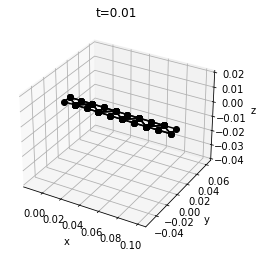

Current time: 0.020000 , End node position: -0.003535
Current time: 0.030000 , End node position: -0.007218
Current time: 0.040000 , End node position: -0.011930
Current time: 0.050000 , End node position: -0.017351
Current time: 0.060000 , End node position: -0.023158
Current time: 0.070000 , End node position: -0.029065
Current time: 0.080000 , End node position: -0.034813
Current time: 0.090000 , End node position: -0.040168
Current time: 0.100000 , End node position: -0.044935
Current time: 0.110000 , End node position: -0.048967
Current time: 0.120000 , End node position: -0.052171
Current time: 0.130000 , End node position: -0.054500
Current time: 0.140000 , End node position: -0.055945
Current time: 0.150000 , End node position: -0.056522
Current time: 0.160000 , End node position: -0.056261
Current time: 0.170000 , End node position: -0.055204
Current time: 0.180000 , End node position: -0.053406
Current time: 0.190000 , End node position: -0.050940
Current time: 0.200000 , End

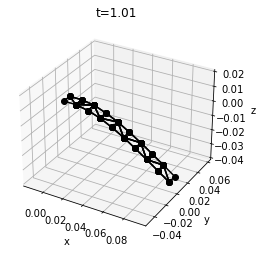

Current time: 1.020000 , End node position: -0.035437
Current time: 1.030000 , End node position: -0.036192
Current time: 1.040000 , End node position: -0.036874
Current time: 1.050000 , End node position: -0.037460
Current time: 1.060000 , End node position: -0.037931
Current time: 1.070000 , End node position: -0.038273
Current time: 1.080000 , End node position: -0.038480
Current time: 1.090000 , End node position: -0.038547
Current time: 1.100000 , End node position: -0.038479
Current time: 1.110000 , End node position: -0.038283
Current time: 1.120000 , End node position: -0.037973
Current time: 1.130000 , End node position: -0.037564
Current time: 1.140000 , End node position: -0.037076
Current time: 1.150000 , End node position: -0.036532
Current time: 1.160000 , End node position: -0.035955
Current time: 1.170000 , End node position: -0.035370
Current time: 1.180000 , End node position: -0.034800
Current time: 1.190000 , End node position: -0.034266
Current time: 1.200000 , End

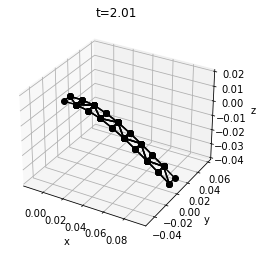

Current time: 2.020000 , End node position: -0.035699
Current time: 2.030000 , End node position: -0.035705
Current time: 2.040000 , End node position: -0.035690
Current time: 2.050000 , End node position: -0.035657
Current time: 2.060000 , End node position: -0.035607
Current time: 2.070000 , End node position: -0.035542
Current time: 2.080000 , End node position: -0.035467
Current time: 2.090000 , End node position: -0.035385
Current time: 2.100000 , End node position: -0.035298
Current time: 2.110000 , End node position: -0.035211
Current time: 2.120000 , End node position: -0.035127
Current time: 2.130000 , End node position: -0.035050
Current time: 2.140000 , End node position: -0.034982
Current time: 2.150000 , End node position: -0.034925
Current time: 2.160000 , End node position: -0.034882
Current time: 2.170000 , End node position: -0.034853
Current time: 2.180000 , End node position: -0.034839
Current time: 2.190000 , End node position: -0.034841
Current time: 2.200000 , End

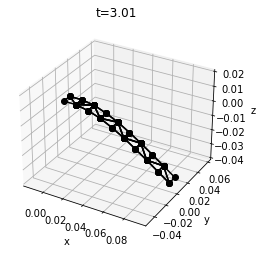

Current time: 3.020000 , End node position: -0.035240
Current time: 3.030000 , End node position: -0.035228
Current time: 3.040000 , End node position: -0.035215
Current time: 3.050000 , End node position: -0.035202
Current time: 3.060000 , End node position: -0.035190
Current time: 3.070000 , End node position: -0.035179
Current time: 3.080000 , End node position: -0.035169
Current time: 3.090000 , End node position: -0.035161
Current time: 3.100000 , End node position: -0.035155
Current time: 3.110000 , End node position: -0.035151
Current time: 3.120000 , End node position: -0.035150
Current time: 3.130000 , End node position: -0.035150
Current time: 3.140000 , End node position: -0.035153
Current time: 3.150000 , End node position: -0.035158
Current time: 3.160000 , End node position: -0.035164
Current time: 3.170000 , End node position: -0.035172
Current time: 3.180000 , End node position: -0.035181
Current time: 3.190000 , End node position: -0.035190
Current time: 3.200000 , End

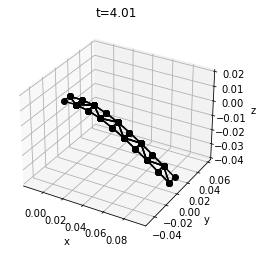

Current time: 4.020000 , End node position: -0.035198
Current time: 4.030000 , End node position: -0.035197
Current time: 4.040000 , End node position: -0.035197
Current time: 4.050000 , End node position: -0.035196
Current time: 4.060000 , End node position: -0.035196
Current time: 4.070000 , End node position: -0.035196
Current time: 4.080000 , End node position: -0.035197
Current time: 4.090000 , End node position: -0.035197
Current time: 4.100000 , End node position: -0.035198
Current time: 4.110000 , End node position: -0.035199
Current time: 4.120000 , End node position: -0.035201
Current time: 4.130000 , End node position: -0.035202
Current time: 4.140000 , End node position: -0.035204
Current time: 4.150000 , End node position: -0.035205
Current time: 4.160000 , End node position: -0.035206
Current time: 4.170000 , End node position: -0.035207
Current time: 4.180000 , End node position: -0.035208
Current time: 4.190000 , End node position: -0.035209
Current time: 4.200000 , End

In [194]:
Nsteps = round(totalTime / dt) # Number of time steps
ctime = 0 # Current time
endZ = np.zeros(Nsteps) # z-coordinate of the last node

qOld = q0.copy()
uOld = u0.copy()

endZ_0= qOld[-1]

final_timeStep = Nsteps

for timeStep in range(Nsteps):


  qNew, uNew = objfun(qOld, uOld, freeIndex, dt, tol, massVector, massMatrix, ks, refLen, edges, kb, thetaBar, hinges, Fg, visc)
  ctime += dt

  # Update my old positions and velocities
  qOld = qNew.copy()
  uOld = uNew.copy()
  
  nodes = qNew.reshape(-1, 3)
  
  # Store endZ
  endZ[timeStep] = qNew[-1] - endZ_0

  print('Current time: %f' % ctime, ', End node position: %f' % endZ[timeStep] )

  # Plot the shell
  if timeStep % 100 == 0:
    plot_beam(qOld, ctime)

  if ((timeStep*dt) % 0.5 == 0) and (ctime != 0):
    endZ_1secondbefore = endZ[timeStep - int(1.0/dt)]
    endZ_diff = np.abs(endZ[timeStep] - endZ_1secondbefore)
    endZ_percent_diff = (endZ_diff/np.abs(endZ[timeStep])) * 100
    if endZ_percent_diff < 0.1:
      print("End Z position has stabilized.")
      final_timeStep = timeStep
      break

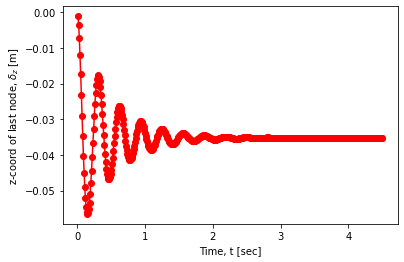

In [ ]:
# Visualize
plt.figure(2)
time_array = np.arange(1, Nsteps+1) * dt

time_array = time_array[0:final_timeStep]
endZ = endZ[0:final_timeStep]
# print(endZ.shape)
# print(time_array.shape)

plt.plot(time_array, endZ, 'ro-')
plt.box(True)
plt.xlabel('Time, t [sec]')
plt.ylabel('z-coord of last node, $\\delta_z$ [m]')
plt.show()

# Compare theoretical with solver

In [ ]:
I = (w*h**3)/12
disp_theory = (q*(l**4)) / (8*Y*I)
print(disp_theory)

-0.03675000000000001
